In [1]:
%cd /home/x_amime/x_amime/projects/an_explanation_model/

/proj/azizpour-group/users/x_amime/projects/an_explanation_model


/home/x_amime/.conda/envs/xlab10/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [52]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import flax
import jax
from matplotlib import pyplot as plt
import numpy as np
import optax 
import tqdm


%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
from glob import glob
import PIL

from scipy.stats import ttest_ind_from_stats as ttest
from source.data_manager import single_query_imagenet
from source.project_manager import load_experiment_metadata
from source.data_manager import preprocess, save_axis


# run this without ? to compute aucs for an experiment
# run this with ? to merge
# run this with ? twice to merge aucs accross experiments
save_metadata_dir = "outputs/metadata/8_1_*_0/"

imshow_args = {"cmap": "jet"}
dataset_dir = "/proj/azizpour-group/datasets/imagenet"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Entropy

In [13]:
df = load_experiment_metadata(save_metadata_dir,)
preds = df[df.stream_name == "log_probs"].data_path.apply(np.load)

<Axes: xlabel='alpha_mask_value'>

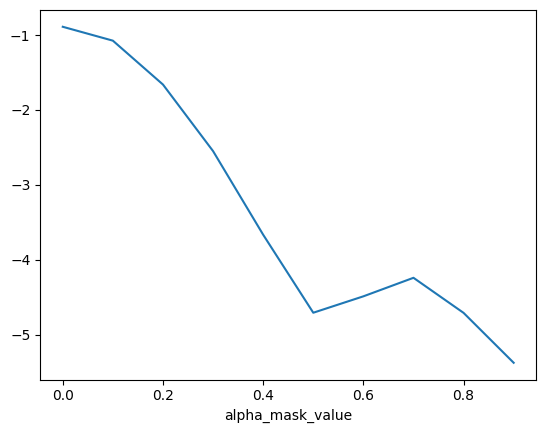

In [10]:
entropies = preds.apply(lambda x: (np.exp(x)*x).sum())
entropies.groupby(df.alpha_mask_value).mean().plot()

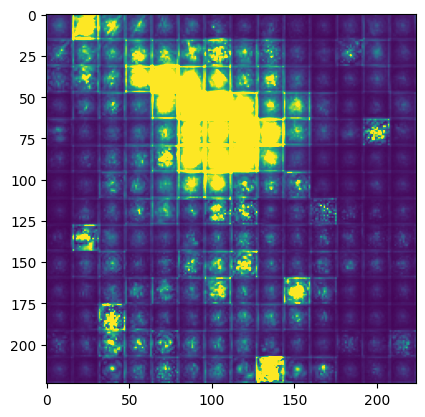

In [45]:
alpha = 0.3
index = 0
temp = df[
    (df.alpha_mask_value == alpha)
    & (df.image_index == index)
    & (df.stream_name == "vanilla_grad_mask")
    & (df.stream_statistic == "meanx2")
]
exp = np.load(temp.data_path.values[0]).sum(axis=-1)
mean = exp.mean()
std = exp.std()
plt.imshow(exp,vmin=0,vmax=mean+std)

In [35]:
temp = df[(df.stream_name=="vanilla_grad_mask") & (df.stream_statistic == "meanx2")]

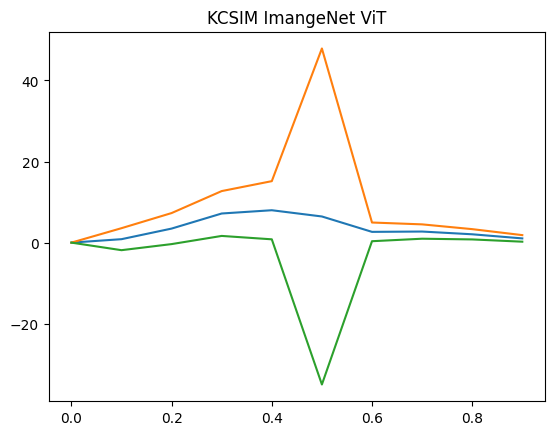

In [38]:
def compute_norm_df(x):
    y = 0
    sigma = x.alpha_mask_value.iloc[0]

    def compute_norm(x):
        x = np.load(x).sum() * (sigma ** (5 / 2))
        return y + x

    y = x["data_path"].apply(compute_norm)
    return y.mean(), y.std()


kcsim= temp.groupby("alpha_mask_value").apply(compute_norm_df)
kcsim_mean = kcsim.apply(lambda x: x[0])
kcsim_std = kcsim.apply(lambda x: x[1])
plt.plot(kcsim_mean, label="mean")
plt.plot(kcsim_mean + kcsim_std, label="mean+std")
plt.plot(kcsim_mean - kcsim_std, label="mean-std")
plt.title("KCSIM ImangeNet ViT")
plt.savefig("outputs/figures/9_imagenetvit_sim_0.pdf", bbox_inches="tight")